In [47]:
#Assignment 3 Statistical Objective Analysis (SOA)
#Original Creator: Jared W. Marquis
#Course: ATSC 528 - Atmospheric Data Analysis

#Author = Christian M Nairy

#Purpose:
#To take sparse upper air observations and analyze them on a polar stereographic map projection using statistical objective analysis (SOA).
#SOA requires the need for a background field, and we also need to find the correlation between observations and observations, 
#as well as observations and background at analysis locations. The process includes bilinear interpolation, forward interpolation, 
#and using the Barnes Scheme.

#Several output files are created (analysis differences, first pass and second pass and third pass txt files, and RMS values txt file.)

In [54]:
#Imports
import numpy as np                  
import matplotlib.pyplot as plt    
import cartopy.crs as ccrs        
import cartopy.feature as cfeature  
import csv

In [3]:
#Create function for a one-pass Barnes Analysis of the observation values to create a background field
#w_dik = exp(-dik^2)/Kd

Kd = 10.8844524 #smoothing param
R1 = 12.7775892 #ROI
Roi_array = np.array([R1]) #the radius of influence put into an array 

def Barnes(dik):
    """
    dik is the distance between the ith analythis points and the kth observation point
    Kd is the smoothing parameter
    """
    w = np.exp(-dik**2/Kd)
    
    return w

In [4]:
#Create function for bilinear interpolation (same setup as the successive corrections lab)
#This was used to find our background

def bilinear(x, y):

    rel_x = x - int(np.floor(x))
    rel_y = y - int(np.floor(y))
    z1 = background_matrix[int(np.floor(y)), int(np.floor(x))]
    z2 = background_matrix[int(np.ceil(y)), int(np.floor(x))]
    z3 = background_matrix[int(np.ceil(y)), int(np.ceil(x))]
    z4 = background_matrix[int(np.floor(y)), int(np.ceil(x))]
    
    p = (((rel_x - 1)*(rel_y - 1)*z1) - ((rel_x)*(rel_y-1)*z2) + (((rel_x)*(rel_y))*z3) - ((rel_x-1)*(rel_y)*z4))
    
    return p

In [7]:
#2nd bilinear function needed to calculate the RMS (root mean square differences), since we do another forward interpolation as well

def bilinear2(x, y, N):
    rel_x = x - int(np.floor(x))
    rel_y = y - int(np.floor(y))
    z1 = analysis_matrix[int(np.floor(y)), int(np.floor(x)), N]
    z2 = analysis_matrix[int(np.ceil(y)), int(np.floor(x)), N]
    z3 = analysis_matrix[int(np.ceil(y)), int(np.ceil(x)), N]
    z4 = analysis_matrix[int(np.floor(y)), int(np.ceil(x)), N]
    
    p = (((rel_x - 1)*(rel_y - 1)*z1) - ((rel_x)*(rel_y-1)*z2) + (((rel_x)*(rel_y))*z3) - ((rel_x-1)*(rel_y)*z4))
    
    return p

In [31]:
#Read in observations
### Read in observations ###
obs = np.loadtxt('RAOBs_201903131200.txt', dtype='str', delimiter=',')

#Make the observations their own data array
obs[:,[1,2,3,4,5]].astype(float) #All obs
ID = obs[:,0] #Station ID
obs_lat = obs[:,1].astype(float) #Latitude
obs_lon = obs[:,2].astype(float) #Longitude
obs_ht = obs[:,3].astype(float) #Heights
wind_dir = obs[:,4].astype(float) #Wind Direction
wind_speed = obs[:,5].astype(float) #Wind Speed

In [21]:
#Convert lat and lon values to radians
obs_lon_radians = (obs_lon * (np.pi/180))
obs_lat_radians = (obs_lat * (np.pi/180))

In [22]:
#Set up analysis map with a 22x28 rectangular grid of points
#known constants
x = 18.9          
y = -6.3          
delta_x = 1.27    
delta_y = 1.27    

In [23]:
#Convert observations to x,y 
x_values = x + np.arange(22)*delta_x              
y_values = y + np.arange(28)* delta_y             
grid_x, grid_y = np.meshgrid(x_values,y_values)  

In [24]:
#Calculate and Define Values
map_proj = 1/(15e6) #map projection
rho = 6371 * 1e5 #radius of Earth
lambda_o = -115
phi_o = 60*(np.pi/180) #radians

#Longitude (from grid to longitude, used for plotting)
new_lon = np.arctan(grid_y/grid_x)*(180/np.pi) + lambda_o 

#Latitude (from grid to latitude,used for plotting
new_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((grid_x/map_proj)**2+(grid_y/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

#Convert lambda knot to radians
lambda_o_radians = (lambda_o * (np.pi/180))

In [25]:
#Equations
#sigma (image scale factor) = (1+sin(phi_knot)/(1+sin(phi))) where phi is a latitude
#r (the radius of any lat circle on the image plane) = rho*sigma*cos(phi)
#x (coordinate) = r*cos(lambda)
#y (coordinate) = r*sin(lambda)
#lambda is the deviation (lambda(knot) - longitude of point) of lon from the standard lon, lambda (knot)

sigma_obs = (1+np.sin(phi_o))/(1+np.sin(obs_lat_radians)) #shows an array of sigma values, which is the scale factor
r_obs = (rho*sigma_obs*(np.cos(obs_lat_radians)))         #shows an array of r values, the radius of any lat circles on the image plane
lambda_obs = ((obs_lon_radians - lambda_o_radians))       #shows an array of the lambda values, deviation of lon from lambda knot

#Convert the latitude and longitude from the text file to x and y

x_obs = (r_obs * (np.cos(lambda_obs))) * map_proj#x coordinate for observations

x_obs = np.array(x_obs)#x coordinate for observations in an array

y_obs = (r_obs * (np.sin(lambda_obs))) *map_proj#y coordinate for observations

y_obs = np.array(y_obs)#y coordinate for observations in an array

#Longitude (from grid to longitude, used for plotting)
obs_lon = np.arctan(y_obs/x_obs)*(180/np.pi) + lambda_o 

#Latitude (from grid to latitude,used for plotting
obs_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_obs/map_proj)**2+(y_obs/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

#Convert from distance on a map to distance on Earth (adjusting the range factor)
phi_4 = 40*(np.pi/180)
phi_eq = ((1+np.sin(phi_o))/(1+np.sin(phi_4)))
map_value = 1.24
map_new_val = map_value/phi_eq

In [26]:
# Create function for Schlatter
# This function is computing the correlations between obs to obs and also analysis to obs

def schlatter(dik):
    """
    p(s) = 0.95exp[-1.24*s^2]
    's' is the distance on the Earth between two points in 1000s of km 
    Use the image scale factor valid at 40N so that this value is constant over the analysis domain
    Note, when s = 0, this equation produces 0.95 while it really should produce 1
    The correlation for distances less than 1km is set equal to 1. Gives you an array of true and falses. Trues get set to 1.
    """
    rho_dik = 0.95 * np.exp(-(map_new_val)*(dik**2))
    rho_dik[dik < 1e-3] = 1
    return rho_dik

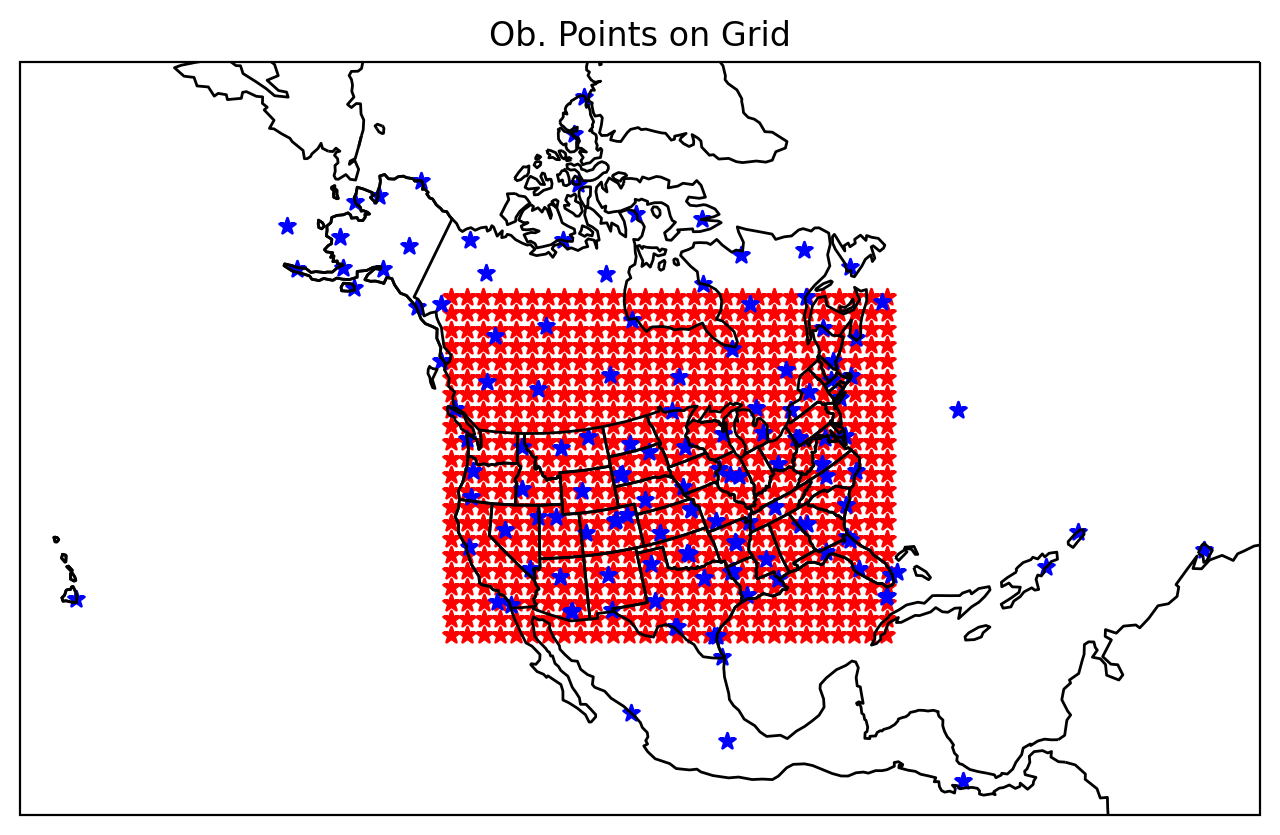

In [27]:
#Plot 500mb analyses with lat/lon to make sure it is working
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(new_lon.ravel(), new_lat.ravel(), c='r', marker="*",transform = ccrs.PlateCarree())
ax1.scatter(obs_lon, obs_lat, marker = "*", c = "blue", transform = ccrs.PlateCarree()) #observations
plt.title('Ob. Points on Grid')
plt.show()

In [28]:
#Find the background field
#The background field is required to perform the univariate statistical objective analysis with the height data

R1 = 12.7775892 #the radius of influence
Roi_array = np.array([R1]) #the radius of influence put into an array for easier calculations
ROI_1 = Roi_array[0] #being extra safe and grabbing just the value because I am afraid

#Define the x and y columns to make the empty matrices to fill with data
y_cols = 28
x_cols = 22

background_matrix = np.empty((y_cols, x_cols)) #this is where the background data is being stored

for j in range(len(grid_x)):
    for k in range(len(grid_x[0])):
        x_dist = grid_x[j,k] - x_obs   #x distance
        y_dist = grid_y[j,k] - y_obs   #y distance
        radius = ((x_dist**2 + y_dist**2)**(1/2)) #distance formula
        index_ROI = np.where(radius <= ROI_1)[0] #these are the observations with the ROI
        weights_matrix = np.zeros(len(x_obs)) #create an empty array to store the weights
        
        for i in index_ROI:
            w = Barnes(radius[i]) #use the Barnes function
            weights_matrix[i] = w #save the values
            
        background_matrix[j, k] = np.sum(weights_matrix * obs_ht) / np.sum(weights_matrix) 

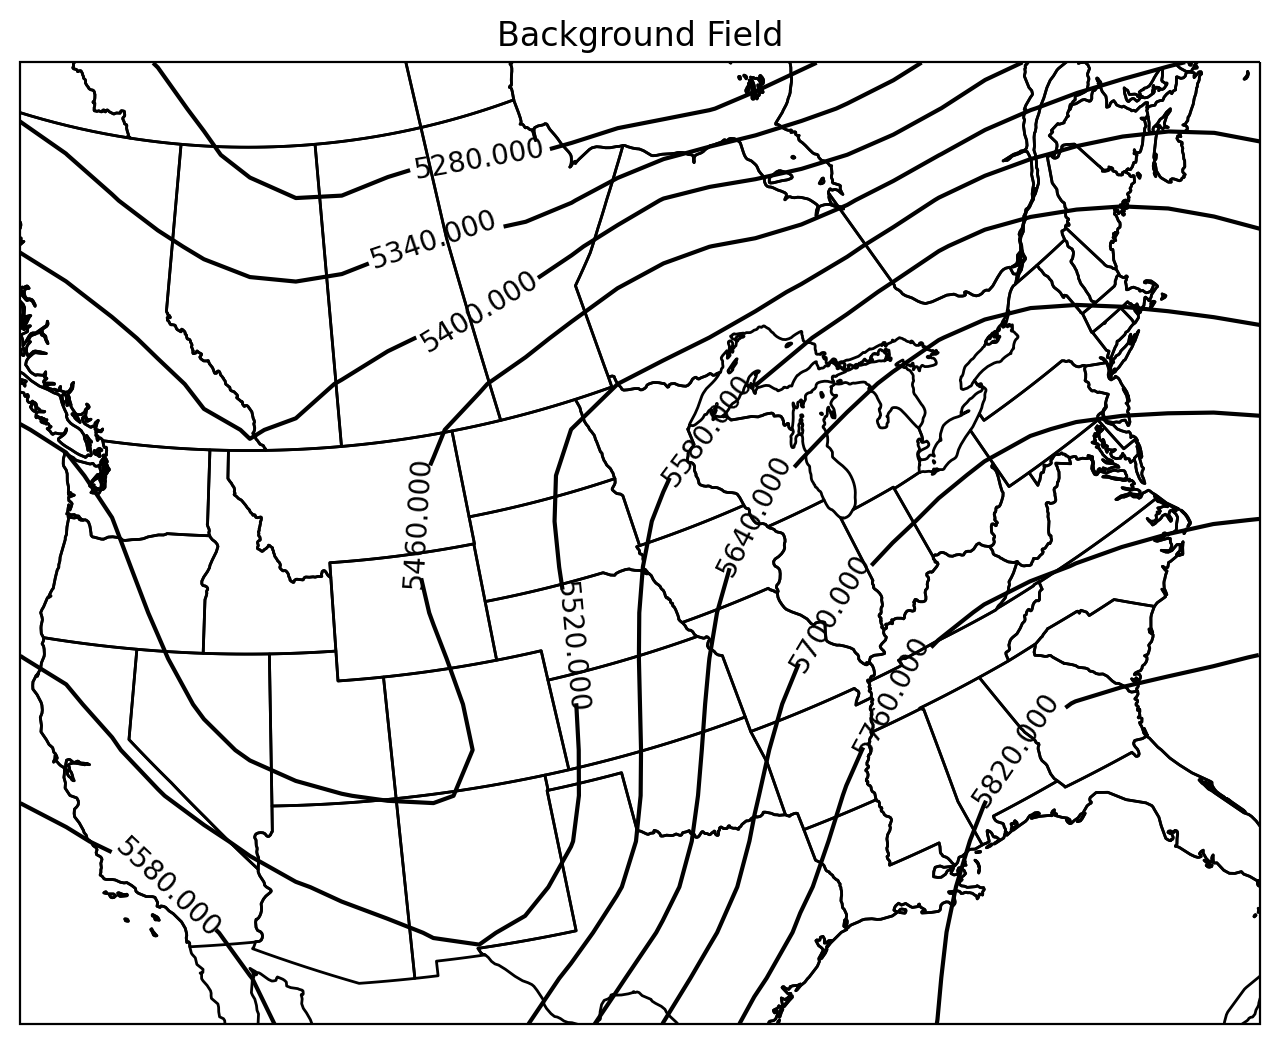

In [32]:
#Plot the Background field
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,background_matrix[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('Background Field')
plt.show()

In [33]:
#Setup for forward interpolation to get the values at the observation locations

ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

P1 = np.zeros(len(x_obs)) #create an empty array to store the bilinear information

#Below is the setup stating if the observation is in the grid, use bilinear. If the observation is not in the grid, do Barnes

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i]) 
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use Barnes
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[0])
        weights_a = np.zeros(grid_x.shape) 
        
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_barnes_a = Barnes(radius_a[j,k]) #do the Barnes
                weights_a[j,k] = weights_barnes_a
                
        p = np.sum(weights_a * background_matrix[:,:])/np.sum(weights_a) #this is the equation (fa-1)(rk). Need to do because no background
        
    P1[i] = p

<ipython-input-33-58dedb758156>:25: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_a * background_matrix[:,:])/np.sum(weights_a) #this is the equation (fa-1)(rk). Need to do because no background


In [34]:
#Perform the analysis (compute the correlations using the Schlatter (1975) model)
#Need to collect the closest values (obs to obs, analysis to obs) before computing the correlations

N = [2,4,10] #list of number of observations (the closest stations)
y_cols = 28
x_cols = 22
analysis_matrix = np.empty((y_cols, x_cols, len(N)))

for n in range(len(N)):
    num_points = N[n]
    for i in range(len(grid_x)):
        for j in range(len(grid_x[i])):
            r = ((grid_x[i,j]-x_obs)**2+(grid_y[i,j]-y_obs)**2)**(1/2)
            new_r = r*(0.15)
            sorted_index = np.argsort(new_r)
            xobs_corr = x_obs[sorted_index[:num_points]]
            yobs_corr = y_obs[sorted_index[:num_points]]
            dist_corr = new_r[sorted_index[:num_points]]
            heights_corr = obs_ht[sorted_index[:num_points]]
            bilinear_corr = P1[sorted_index[:num_points]]
            
            #Calculate the correlation and distance between observations to observations
            correlation_array = np.empty((num_points,num_points))
            correlation_grid_obs = np.empty((num_points,num_points))
            
            for k in range(len(xobs_corr)):
                dik = ((xobs_corr[k]-xobs_corr)**2+(yobs_corr[k]-yobs_corr)**2)**(1/2) #distance between observations and observations
                
                #A-posteriori weights
                correlation_array[k] = schlatter(dik*0.15) #shlatter
        
            #Distance between the analysis points and observations
            correlation_grid_obs = np.matrix(schlatter(dist_corr)).T
            
            weights = np.array(np.linalg.inv(correlation_array)*(correlation_grid_obs)).flatten() #need to flatten to do matrix math so it matches to the other matrix shape
            
            analysis_matrix[i,j,n] = background_matrix[i,j] + np.nansum(weights*(heights_corr-bilinear_corr)) #The analysis equation

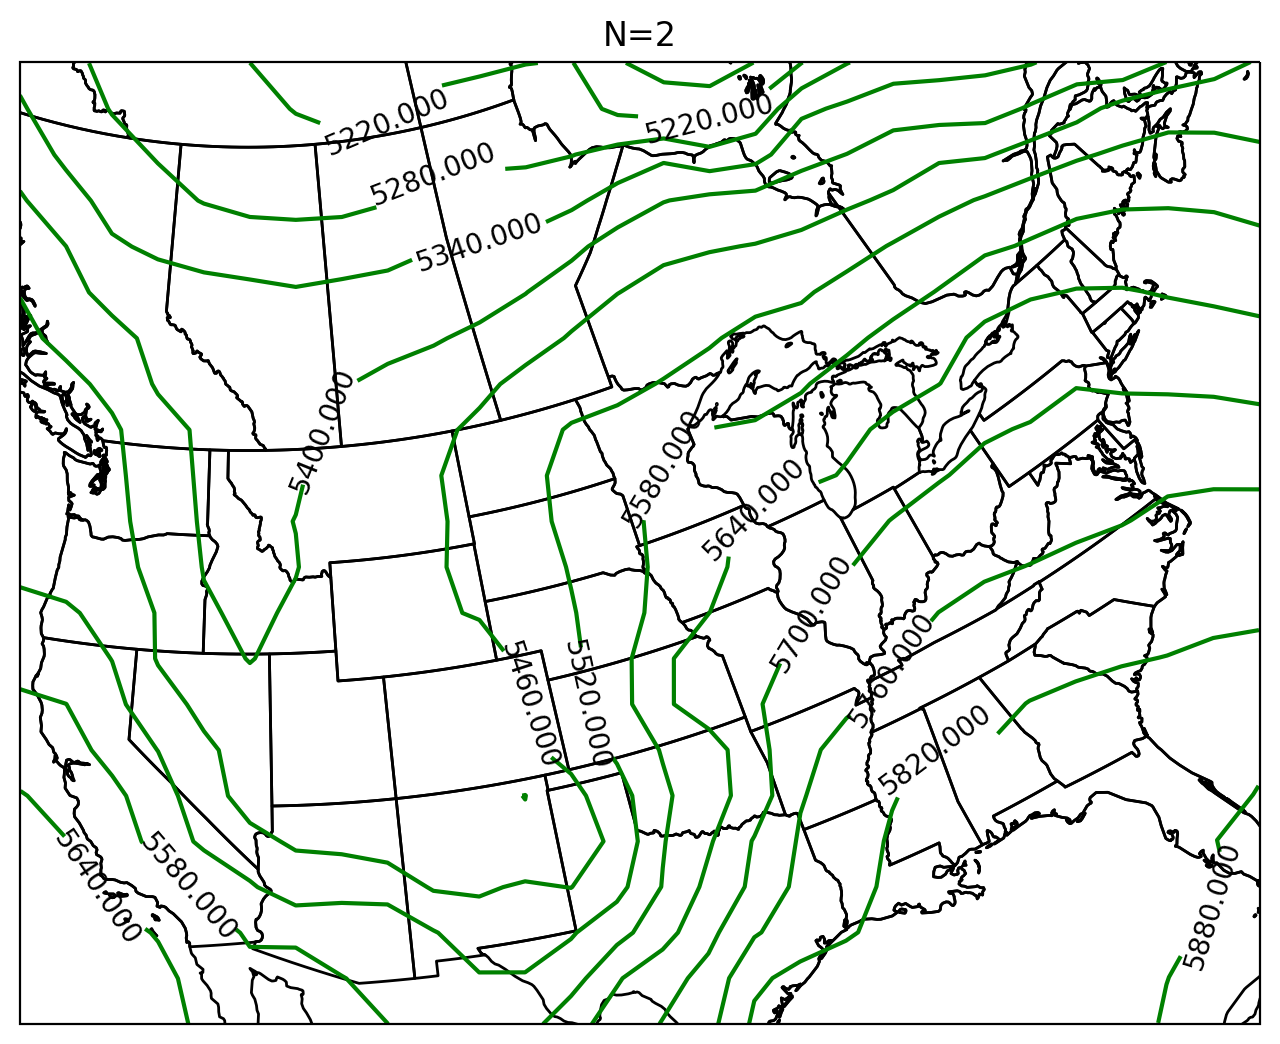

In [53]:
#Plot N=2 analysis
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_matrix[:,:,0],colors='green',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('N=2')
plt.show()

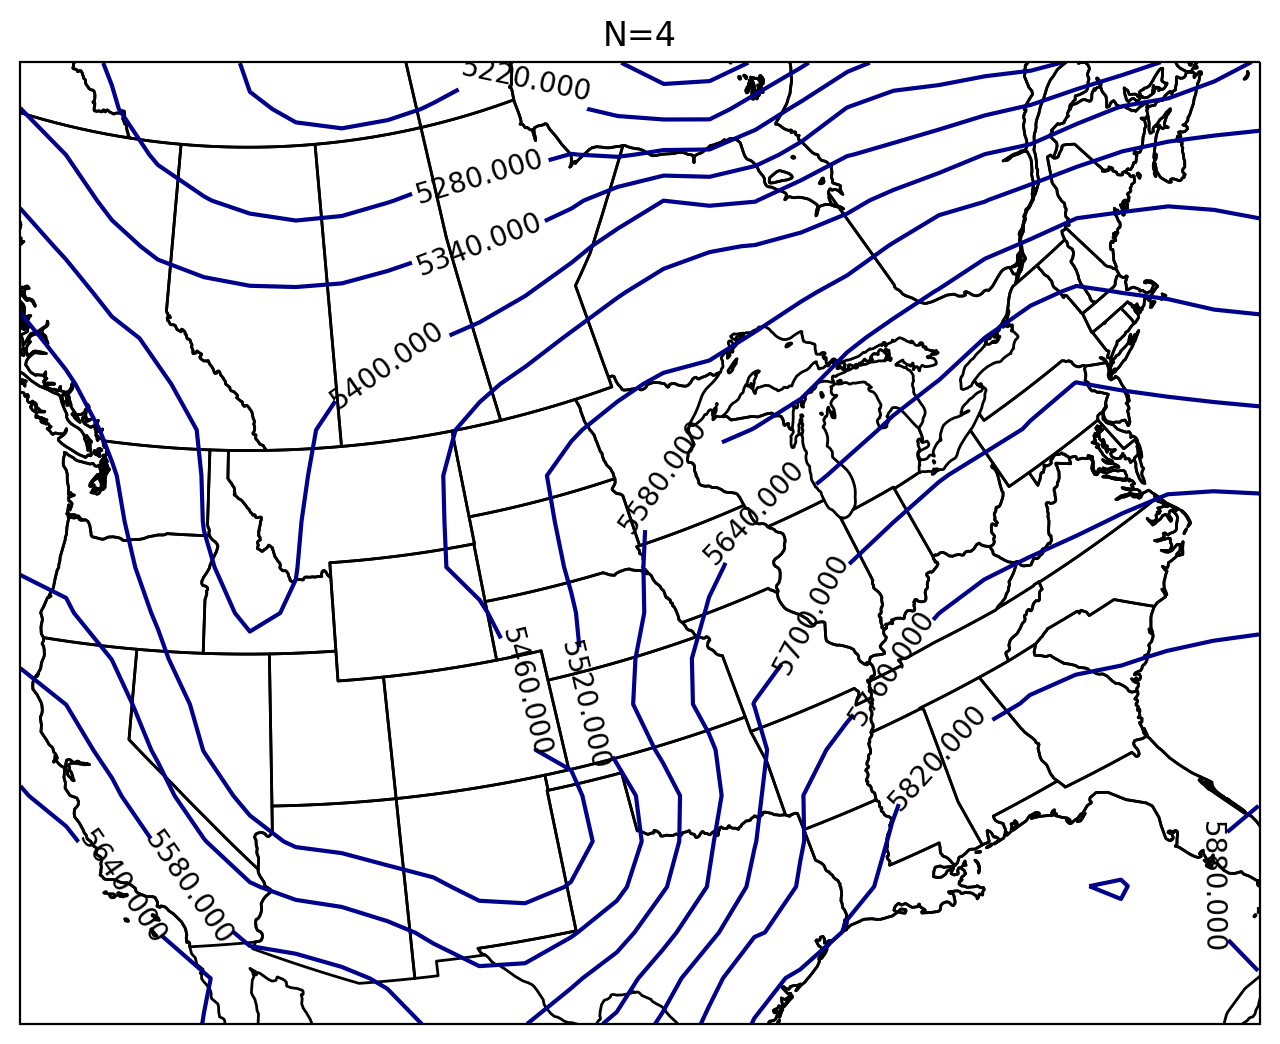

In [52]:
#Plot N=4 analysis
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_matrix[:,:,1],colors='darkblue',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('N=4')
plt.show()

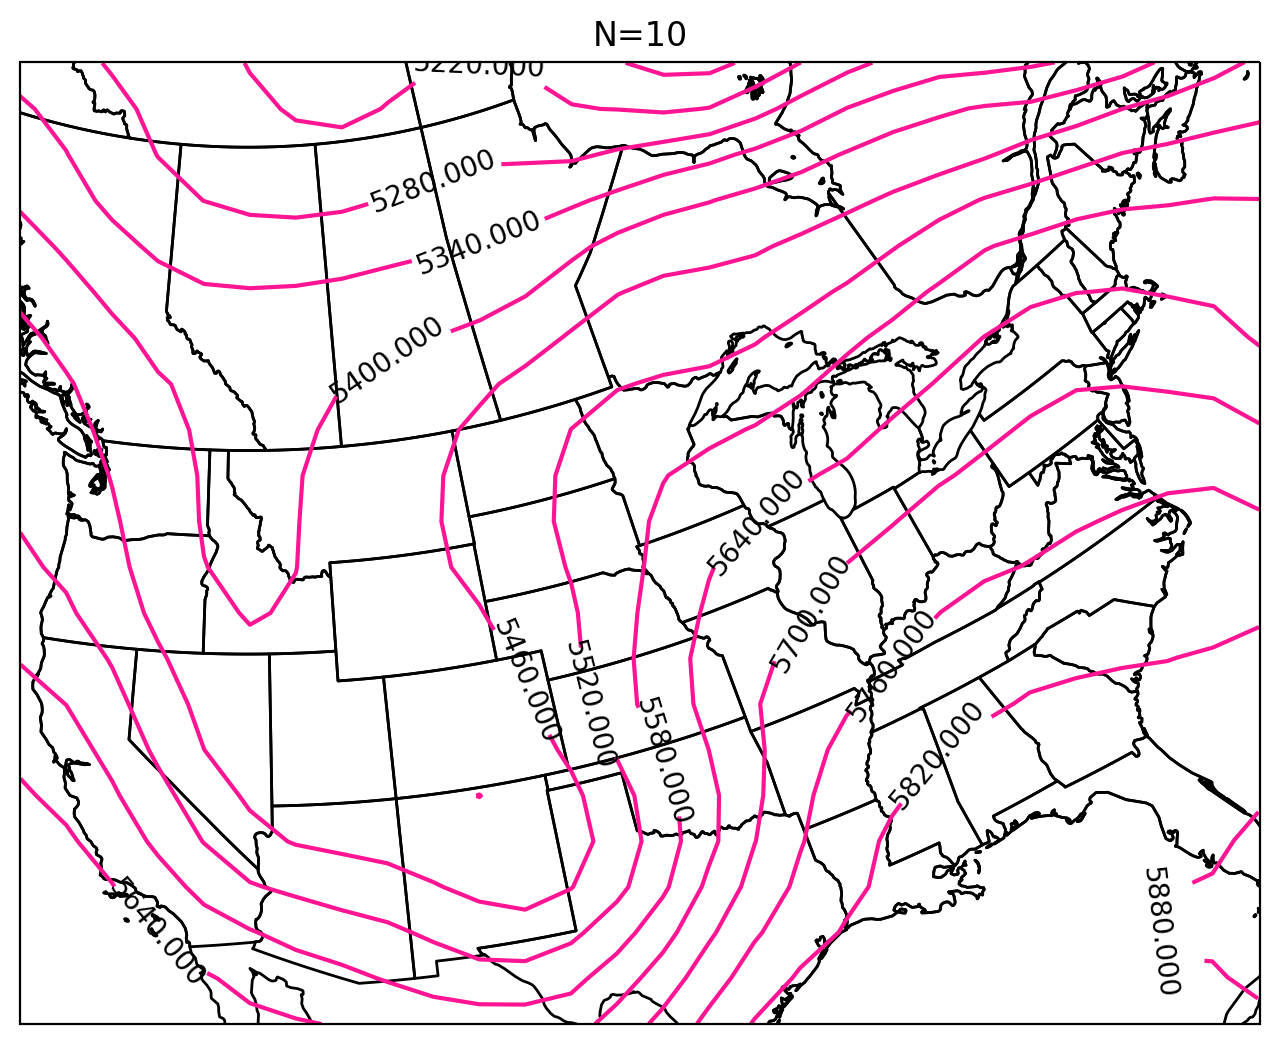

In [37]:
#Plot N=10 analysis
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_matrix[:,:,2],colors='deeppink',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree()) #pink for Taylor...
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('N=10')
plt.show()

In [38]:
#Analysis Increment (Between the raw values and plotted values)
analysis_increment_n2 = analysis_matrix[:,:,0] - background_matrix[:,:]
analysis_increment_n4 = analysis_matrix[:,:,1] - background_matrix[:,:]
analysis_increment_n10 = analysis_matrix[:,:,2] - background_matrix[:,:]

#Store the analysis increments in text files
np.savetxt("N2_Analysis_Inc.txt", analysis_increment_n2, delimiter = ',')
np.savetxt("N4_Analysis_Inc.txt", analysis_increment_n4, delimiter = ',')
np.savetxt("N10_Analysis_Inc.txt", analysis_increment_n10, delimiter = ',')

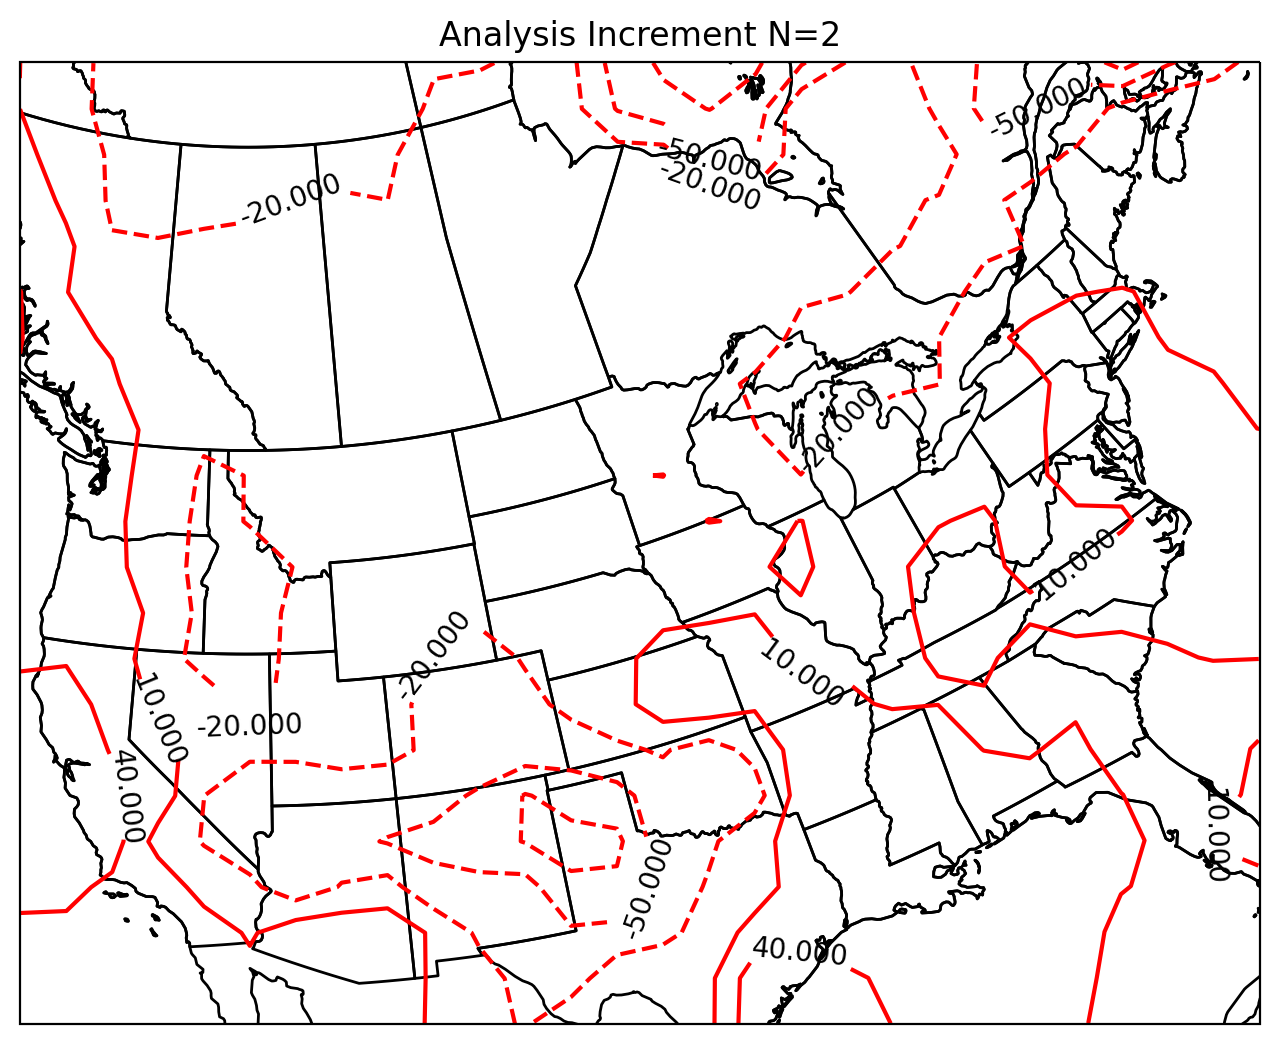

In [61]:
#Plot N=2 Analysis Increment
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_increment_n2,colors='red',levels=np.arange(-8000,8000,30),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,30), colors = 'black')
plt.title('Analysis Increment N=2')
plt.show()

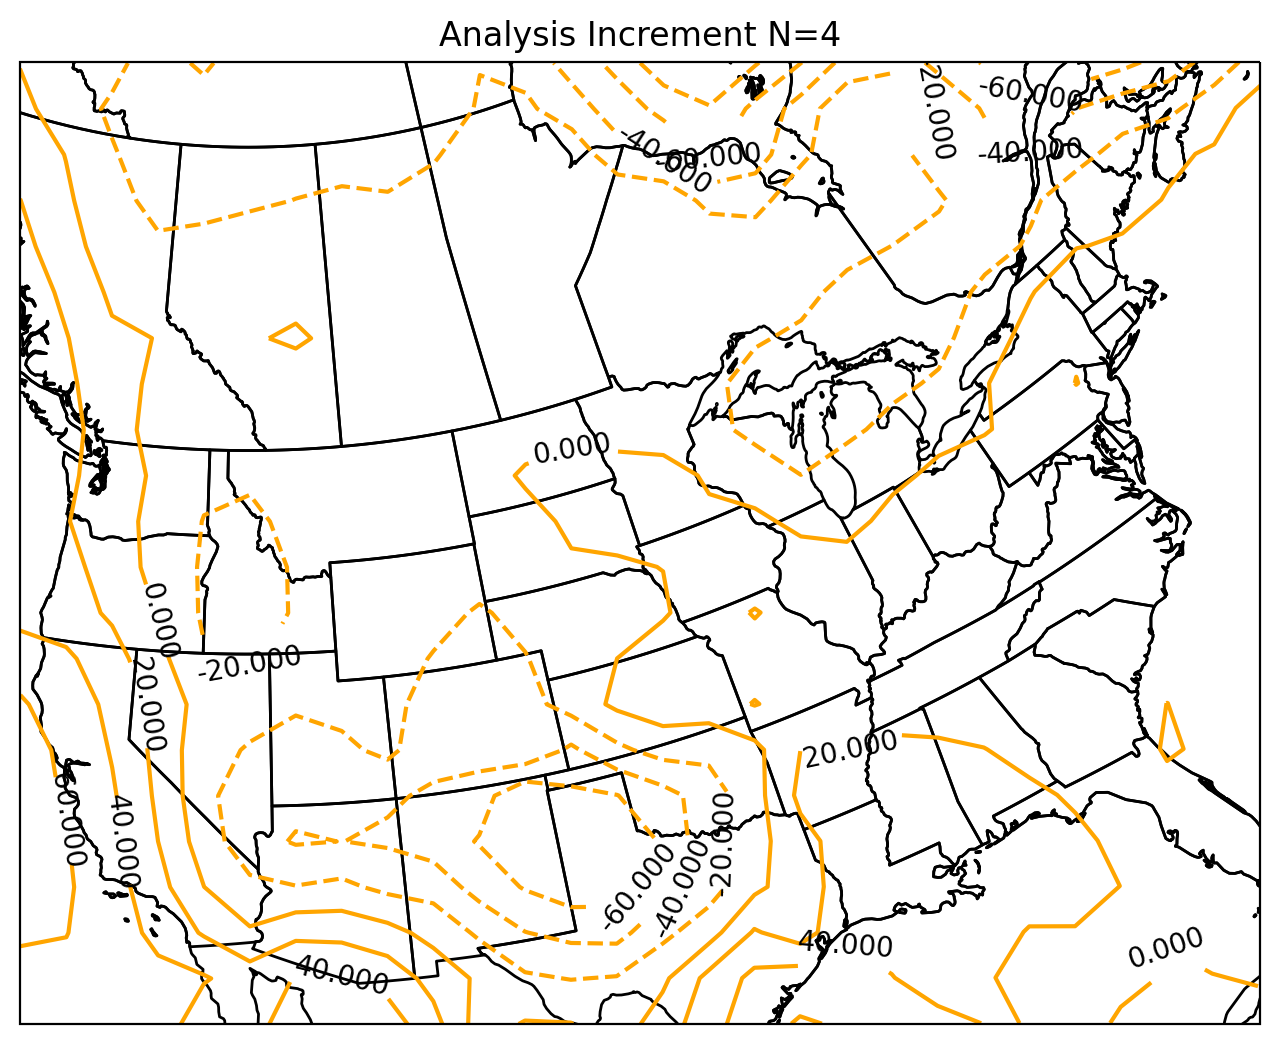

In [62]:
#Plot N=4 Analysis Increment
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_increment_n4,colors='orange',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20), colors = 'black')
plt.title('Analysis Increment N=4')
plt.show()

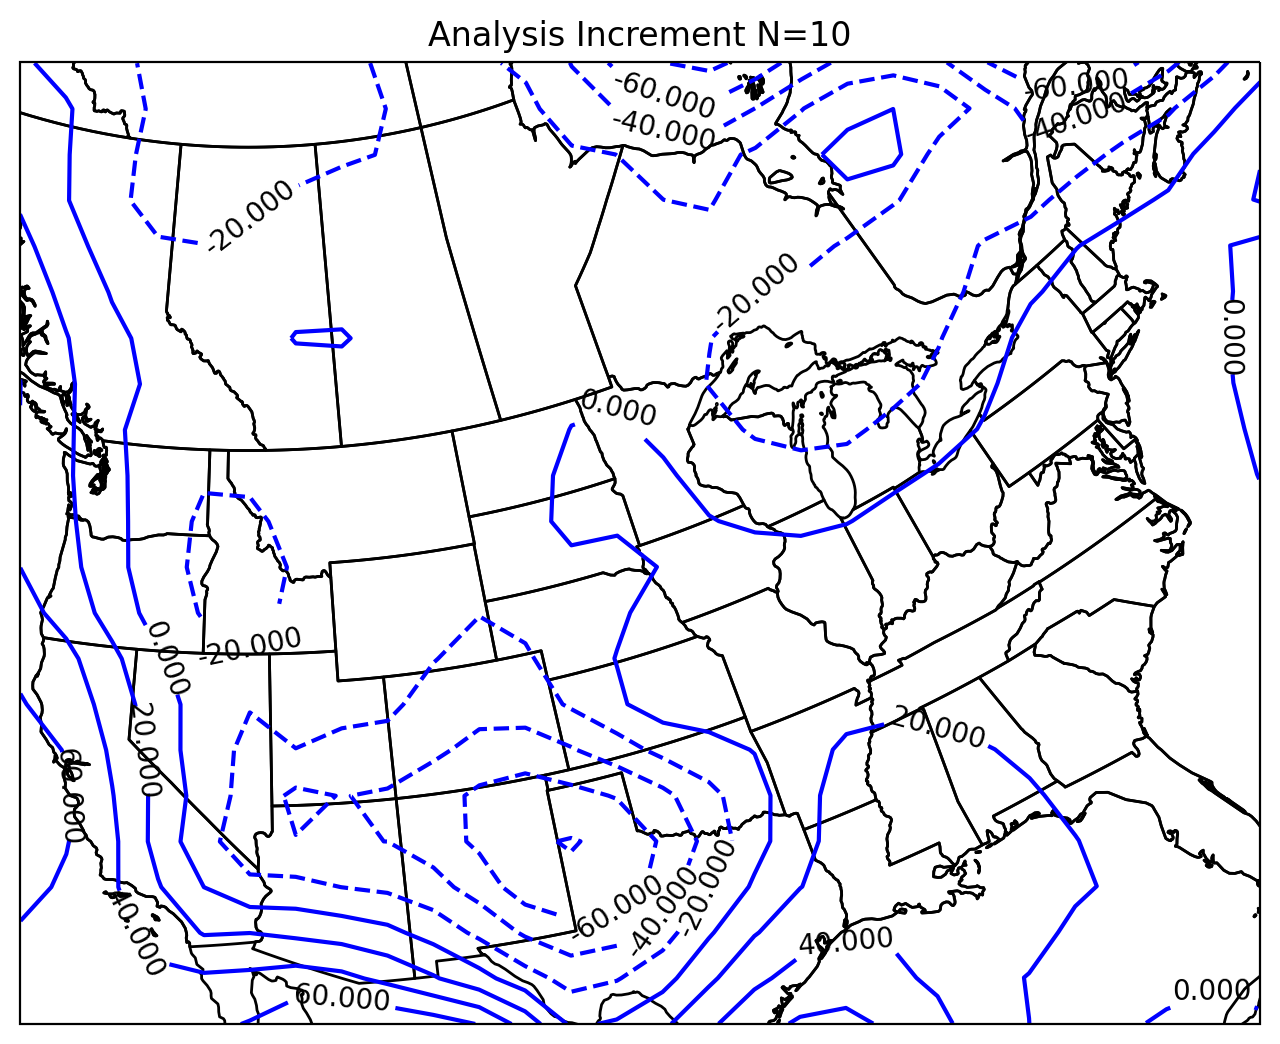

In [63]:
#Plot N=10 Analysis Increment
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_increment_n10,colors='blue',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20), colors = 'black')
plt.title('Analysis Increment N=10')
plt.show()

In [42]:
#Find the Analysis differences (N=2)
#To do each analysis difference, this requires a forward interpolation of the analysis values
#To complete this, we need to do the same bilinear interpolation for observations within the grid and then a pass of the Barnes

Roi_array = np.array([R1])
ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

result_0 = np.zeros(len(x_obs)) #empty array to store the data

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear2(ind_x[i], ind_y[i], 0) #the zero is using your analysis values from your first pass  
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use a reverse Barnes
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[0])
        weights_a = np.zeros(grid_x.shape) #Make the grid
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_barnes = Barnes(radius_a[j,k]) 
                weights_a[j,k] = weights_barnes
        p = np.sum(weights_a * analysis_matrix[:,:,0])/np.sum(weights_a)
        
    result_0[i] = p

<ipython-input-42-2d7756103881>:24: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_a * analysis_matrix[:,:,0])/np.sum(weights_a)


In [43]:
#Find the Analysis differences (N=4)
#forward interpolation of the analysis values
#bilinear interpolation for observations within the grid and then a pass of the Barnes

Roi_array = np.array([R1])
ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

result_1 = np.zeros(len(x_obs)) #empty array to store bilinear

#Same analysis as above, just for the N=4 (so the 0 in the first 'p' above got changed to a 1, since this is the second value in the array)

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear2(ind_x[i], ind_y[i], 1) 
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use a reverse Barnes
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[0])
        weights_a = np.zeros(grid_x.shape) #Make the grid
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_barnes = Barnes(radius_a[j,k]) 
                weights_a[j,k] = weights_barnes
        p = np.sum(weights_a * analysis_matrix[:,:,1])/np.sum(weights_a)
        
    result_1[i] = p

<ipython-input-43-425a46c005d9>:26: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_a * analysis_matrix[:,:,1])/np.sum(weights_a)


In [44]:
#Find the Analysis differences (N=10)
#To do each analysis difference, this requires a forward interpolation of the analysis values
#To complete this, we need to do the same bilinear interpolation for observations within the grid and then a pass of the Barnes

Roi_array = np.array([R1])
ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

result_2 = np.zeros(len(x_obs)) #empty array to store bilinear

#Same analysis as above, just for the N=4 (so the 1 in the first 'p' above got changed to a 2, since this is the third value in the array)

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear2(ind_x[i], ind_y[i], 2)  
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use a reverse Barnes
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[0])
        weights_a = np.zeros(grid_x.shape) #Make the grid
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_barnes = Barnes(radius_a[j,k]) 
                weights_a[j,k] = weights_barnes
        p = np.sum(weights_a * analysis_matrix[:,:,2])/np.sum(weights_a)
        
    result_2[i] = p

<ipython-input-44-33bbc79dce39>:26: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_a * analysis_matrix[:,:,2])/np.sum(weights_a)


In [57]:
#Store the analysis differences in text files

np.savetxt("N2_Analysis_Difference.txt", result_0, delimiter = ',')
np.savetxt("N4_Analysis_Difference.txt", result_1, delimiter = ',')
np.savetxt("N10_Analysis_Difference.txt", result_2, delimiter = ',')

In [56]:
#Root mean square diff for Analysis 1 (N=2)
diff_1 = (obs_ht - result_0)**2
diff_1 = diff_1[~np.isnan(diff_1)]
rms_1 = np.sqrt((np.sum(diff_1))/len(diff_1))

#Root mean square diff for Analysis 2 (N=4)
diff_2 = (obs_ht - result_1)**2
diff_2 = diff_2[~np.isnan(diff_2)]
rms_2 = np.sqrt((np.sum(diff_2))/len(diff_2))

#Root mean square diff for Analysis 3 (N=10)
diff_3 = (obs_ht - result_2)**2
diff_3 = diff_3[~np.isnan(diff_3)]
rms_3 = np.sqrt((np.sum(diff_3))/len(diff_3))

rms_list = list([rms_1, rms_2, rms_3]) #51, 49, 50

#Store RMS list in a text file
np.savetxt("RMSE_values.txt", rms_list)

In [55]:
#Store the analyses (raw values) in text files

a_file = open("First_Pass.txt", "w") 
for line in analysis_matrix[:,:,0]:
    np.savetxt(a_file, line)
a_file.close()   

b_file= open("Second_Pass.txt", "w") 
for line in analysis_matrix[:,:,1]:
    np.savetxt(b_file, line)
b_file.close()   

c_file = open("Third_Pass.txt", "w") 
for line in analysis_matrix[:,:,2]:
    np.savetxt(c_file, line)
c_file.close()    

In [48]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

ANSWER: In all of the contoured analyses plotted you can clearly see a upper-level trough over the 
        western CONUS digging into New Mexico and the Texas panhandle. Conversely, there is an upper-
        level ridge over the central and eastern CONUS.

2 - Describe the differences that you see in your contoured analyses. Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
ANSWER: 

        - In the N=2 analysis, the contours do not seem as smooth when compared to the other analyses (jagged and riggid).
        - N=4 is smoother than the N=2 analysis, but has something weird going on in the Gulf.
        - The 5880 contour in Florida also changed shape a bit. When the N=4 and the
        - The N=10 contour is the smoothest plot. The large scale features are more defined. The 5880 contour in 
          Florida is a bit weird, and it seems to progressivly get worse from N=2 to N=10 analyses. There is also a tiny
          dot in NM?? Which is very odd.
    
        - The small scale features and movements are more defined in the N=2 analysis since this analysis only uses the two CLOSEST stations, 
          meaning there are limited # of observations. Limited # of observations = smaller features are more apparent. When you increase the number 
          of observations (going from N=4 to N=10), those small features get  smoothed out, but the general large scale pattern are still present.

3 - What happens as you increase the number of points considered for the analysis? Is this desirable? Why or why not?
    
ANSWER: When you increase the number of points in our case, little change occurs in the plots provided. In other cases, 
        this might not always be the case. The analysis map can only become so smooth with the increase number of passes, 
        so to an extent you can increase the number of observations (N values). We saw smoothing of the contours from N=2 to N=10 
        which is good and desirable, but as you increase higher after N=10, the contours all look similar and very little 
        changes to the overall plot.
    
'''

'\n1 - Describe the general features that you see in your contoured analyses.\n\n    There is a large trough pattern over New Mexico and Colorado (trough dips all way down) in all three analyses and is greatly defined, with good gradient. There is a more \n    defined/sharp/rough looking trough over Idaho in all three analyses. A ridge feature is seen starting in Georgia and is titled to the northwest in all three analyses. \n    In the N=10 and the N=2 analysis, there is a weird dot in New Mexico. In all three analyses, the 5880 contour in Florida seems a little off and mishapen. \n    The last thing is a little blob in the N=4 map over the Gulf.\n\n2 - Describe the differences that you see in your contoured analyses. Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n    In the N=2 analysis, the contours do not seem as smooth/connected when compared to the other analyses. The lines are also a bit more jagged. The N=2 shows the tiny, small\n   